### LIB (R)

In [2]:
# bibliotecas do python
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
import rpy2.robjects.packages as rpackages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# bibliotecas do R
base = importr('base')
utils = importr('utils')
utils.chooseCRANmirror(ind=1)
ts_analysis = ('urca','tseries','forecast','e1071','Metrics')

from rpy2.robjects.vectors import StrVector
utils.install_packages(StrVector(ts_analysis))

(as ‘lib’ is unspecified)



























	‘/tmp/RtmpN1iHCz/downloaded_packages’



<rpy2.rinterface_lib.sexp.NULLType object at 0x7ff7e2ea8870> [RTYPES.NILSXP]

In [4]:
# importando as bibliotecas do R usadas para predição
# acho que so precisa importar uma vez. (demora)

urca = importr('urca')
tseries = importr('tseries')
forecast = importr('forecast')
e1071 = importr('e1071')
metrics = importr('Metrics')

In [5]:
# %R - "linha mágica" - retorna valor como objeto python

# %%R - "célula mágica" - nao retorna valor mas consegue passar input e output  

# Arguments
# -i  -  variaveis de input
# -o  -  variaveis de output
# -h  -  altura do plot
# -w  -  largura do plot


%load_ext rpy2.ipython

In [6]:
import requests
from datetime import date, datetime
from calendar import timegm

today = date.today()

base = "http://monipe-central.rnp.br"


def get_data(url_slice, time_range):
    url = base+url_slice
    header = {"time-range": time_range}
    response = requests.get(url, params=header)
    json_data = response.json()
    return json_data


def request_by_metadata_key(url, type):
    url_ = url
    response = requests.get(url_)
    json_data = response.json()
    if (response.status_code == 200):
        for obj in json_data["event-types"]:
            if obj["event-type"] == type:
                return obj
    else:
        return response.status_code


def calc_mean(val):
    values = []
    for key, value in val.items():
        values.append(float(key)*value)
    return sum(values)/len(values)


def request(name, source, destination, type, time_range, target_bandwidth="9999999999"):
    url = "http://monipe-central.rnp.br/esmond/perfsonar/archive/?"
    hearder = {"pscheduler-test-type": type, "source": source, "destination": destination,
               "bw-target-bandwidth": target_bandwidth, "time-range": time_range}
    response = requests.get(url, params=hearder)
    json_data = response.json()
    if (response.status_code == 200):
        datas = []
        for obj in json_data:
            url_obj = obj["url"]
            get_url_base_obj = request_by_metadata_key(url_obj, type)
            if (not isinstance(get_url_base_obj, int)):
                url_base = get_url_base_obj["base-uri"]
                f = open(name+" esmond data " +
                         today.strftime("%m-%d-%Y")+".csv", "w")
                data = get_data(url_base, time_range)
                datas.insert(0, data)
            else:
                return "Error " + response.status_code
        teste = []
        for i in range(len(datas)):
            cont = 0
            soma = 0
            anterior = None
            for obj in datas[i]:
                data = datetime.fromtimestamp(int(obj["ts"]))
                dia = str(data).split()[0][-2::]
                if (str(data).split()[0][-5::]) not in teste:
                    teste.append(str(data).split()[0][-5::])
                if dia == anterior or anterior is None:
                    soma += obj["val"]
                    cont += 1
                    f.write(datetime.fromtimestamp(int(obj["ts"])).strftime(
                        '%Y-%m-%d %H:%M:%S')+", "+str(obj["val"])+"\n")
                else:
                    media = soma/cont
                    ciclos = 6-cont
                    for i in range(ciclos):
                        cont += 1
                        f.write(datetime.fromtimestamp(
                            int(obj["ts"]-86400)).strftime('%Y-%m-%d %H:%M:%S')+", "+str(media)+"\n")
                    soma = 0
                if cont == 6:
                    cont = 0
                    anterior = None
                else:
                    anterior = dia
        print(len(teste)*6)
        for i in teste:
            print(i)
        f.close()
    else:
        return "Error: " + response.status_code


def request_atraso(name, source, destination, type, time_range):
    url = "http://monipe-central.rnp.br/esmond/perfsonar/archive/?"
    hearder = {"pscheduler-test-type": type, "source": source,
               "destination": destination, "time-range": time_range}
    response = requests.get(url, params=hearder)
    json_data = response.json()
    values = []
    if (response.status_code == 200):
        print("Ok")
        bases = []
        for obj in json_data:
            types_list = obj['event-types']
            for obj_types in types_list:
                if obj_types.get('event-type') == 'histogram-owdelay':
                    bases.append(obj_types.get('base-uri'))
                    break
        with open(name+" esmond data " + today.strftime("%m-%d-%Y")+".csv", "w") as f:
            for link in bases:
                values = get_data(link, time_range)
                for value in values:
                    value['val'] = calc_mean(value['val'])
                    f.write(f"{value['ts']}, {value['val']}\n")


# request("cubic", "monipe-ce-banda.rnp.br", "monipe-sp-banda.rnp.br", "throughput", "15552000") # 6 meses
# request("bbr", "monipe-ce-banda.rnp.br", "monipe-sp-banda.rnp.br", "throughput", "15552000", "10000000000") # 6 meses

request_atraso("atraso", "monipe-ce-atraso.rnp.br",
               "monipe-sp-atraso.rnp.br", "latencybg", "7776000")

Ok


### Throughput Total (PRA - Remoção de Erros de Ciclo)

In [7]:
TS = pd.read_csv(r'/content/cubic esmond data 09-09-2022.csv')

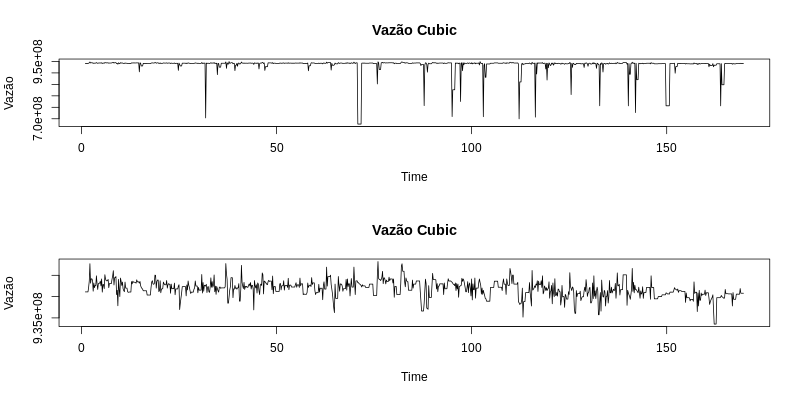

In [8]:
%%R -i TS -h 400 -w 800 -o TScubic

TS_R = TS

TScubic = ts(TS_R[,2], start = c(1, 1), frequency = 6)

TScubic_clean = tsclean(TScubic)

par (mfrow = c(2,1))
plot(TScubic, main = "Vazão Cubic", ylab = "Vazão")
plot(TScubic_clean, main = "Vazão Cubic", ylab = "Vazão")

In [9]:
%%R -w 700 -h 400 # Decomposição da Série (Observação de tendencia e sazonaliadade)

tsadditive_clean = decompose(TScubic_clean, type = "additive")
tsmult_clean = decompose(TScubic_clean, type = "multiplicative")
tsadditive = decompose(TScubic, type = "additive")
tsmult = decompose(TScubic, type = "multiplicative")

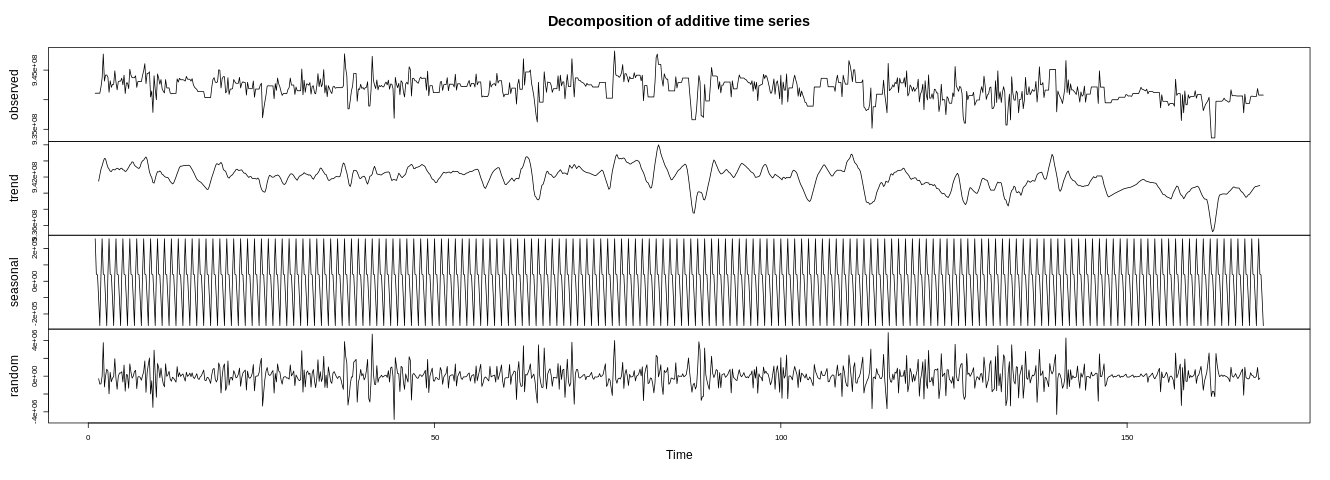

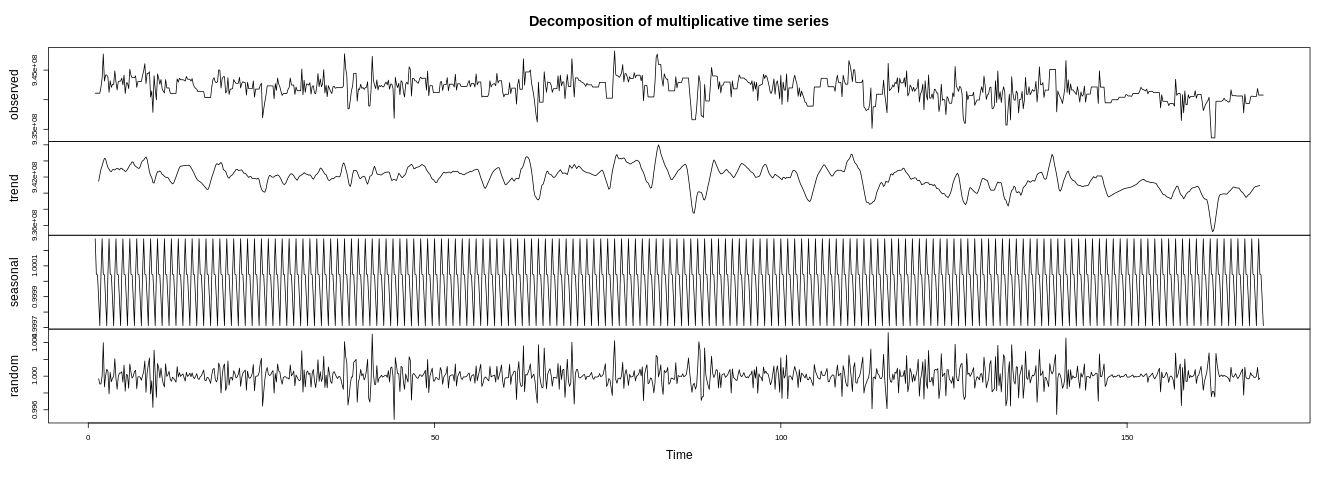

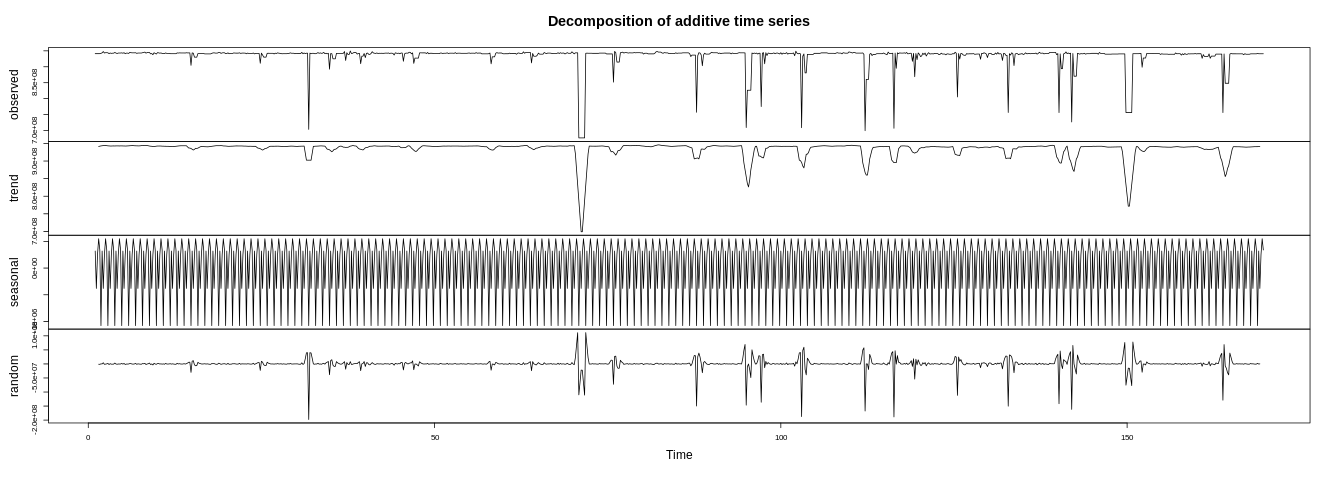

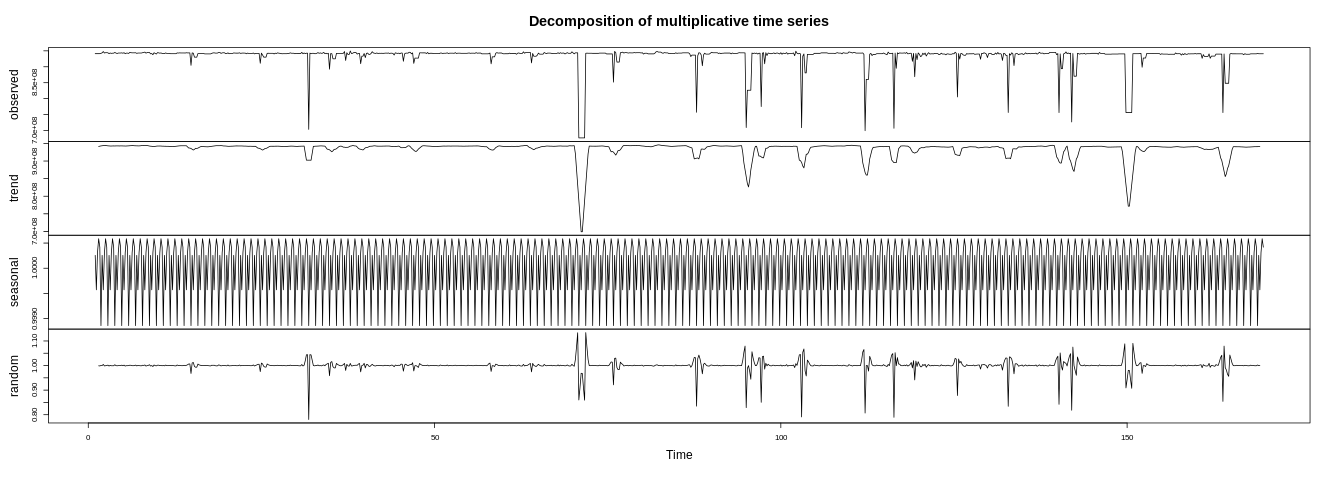

In [10]:
%%R -w 1330

par(mfrow=c(4,1))
plot(tsadditive_clean)
plot(tsmult_clean)
plot(tsadditive)
plot(tsmult)

In [11]:
%%R -o random_ad # Variavel aleatoria

random_ad_c = tsadditive_clean$random
random_ad = tsadditive$random
random_mt_c = tsmult_clean$random
random_mt = tsmult$random

In [12]:
%%R 
random_ad = na.omit(random_ad)
random_mt = na.omit(random_mt)
random_ad_c = na.omit(random_ad_c)
random_mt_c = na.omit(random_mt_c)

### Teste de Estacionariedade (Serie Total - Observação)

In [13]:
%%R -h 400 -w 1000 # Teste de estacionariedade para cada tipo de decomposição

kpss_add = ur.kpss(random_ad)
kpss_mul = ur.kpss(random_mt)

kpss_addc = ur.kpss(random_ad_c)
kpss_mulc = ur.kpss(random_mt_c)

adf_add = ur.df(random_ad)
adf_mul = ur.df(random_mt)

adf_addc = ur.df(random_ad_c)
adf_mulc = ur.df(random_mt_c)

In [14]:
%%R

print(kpss_add)
print(kpss_mul)
print(kpss_addc)
print(kpss_mulc)

print(adf_add)
print(adf_mul)
print(adf_addc)
print(adf_mulc)

# Usar o TS clean


####################################### 
# KPSS Unit Root / Cointegration Test # 
####################################### 

The value of the test statistic is: 0.0036 


####################################### 
# KPSS Unit Root / Cointegration Test # 
####################################### 

The value of the test statistic is: 0.0053 


####################################### 
# KPSS Unit Root / Cointegration Test # 
####################################### 

The value of the test statistic is: 0.0039 


####################################### 
# KPSS Unit Root / Cointegration Test # 
####################################### 

The value of the test statistic is: 0.0039 


############################################################### 
# Augmented Dickey-Fuller Test Unit Root / Cointegration Test # 
############################################################### 

The value of the test statistic is: -32.0823 


############################################################### 
# Augmente

In [15]:
%%R

#kpss_add@teststat

NULL


### Separar Conjuntos

In [39]:
%%R # Separar conjuntos de treino

conjunto_treino = c("mytsTrain8",
                    "mytsTrain16",
                    "mytsTrain24",
                    "mytsTrain32",
                    "mytsTrain40",
                    "mytsTrain48",
                    "mytsTrain56",
                    "mytsTrain64",
                    "mytsTrain72",
                    "mytsTrain80",
                    "mytsTrain88",
                    "mytsTrain96",
                    "mytsTrain104",
                    "mytsTrain112",
                    "mytsTrain120",
                    "mytsTrain128",
                    "mytsTrain136",
                    "mytsTrain144",
                    "mytsTrain152",
                    "mytsTrain160",
                    "mytsTrain168"
)

mytsTrain8 = window(random_ad, start = c(1,1), end = c(8,6))
mytsTrain16 = window(random_ad, start = c(1,1), end = c(16,6))
mytsTrain24 = window(random_ad, start = c(1,1), end = c(24,6))
mytsTrain32 = window(random_ad, start = c(1,1), end = c(32,6))
mytsTrain40 = window(random_ad, start = c(1,1), end = c(40,6))
mytsTrain48 = window(random_ad, start = c(1,1), end = c(48,6))
mytsTrain56 = window(random_ad, start = c(1,1), end = c(56,6))
mytsTrain64 = window(random_ad, start = c(1,1), end = c(64,6))
mytsTrain72 = window(random_ad, start = c(1,1), end = c(72,6))
mytsTrain80 = window(random_ad, start = c(1,1), end = c(80,6))
mytsTrain88 = window(random_ad, start = c(1,1), end = c(88,6))
mytsTrain96 = window(random_ad, start = c(1,1), end = c(96,6))
mytsTrain104 = window(random_ad, start = c(1,1), end = c(104,6))
mytsTrain112 = window(random_ad, start = c(1,1), end = c(112,6))
mytsTrain120 = window(random_ad, start = c(1,1), end = c(120,6))
mytsTrain128 = window(random_ad, start = c(1,1), end = c(128,6))
mytsTrain136 = window(random_ad, start = c(1,1), end = c(136,6))
mytsTrain144 = window(random_ad, start = c(1,1), end = c(144,6))
mytsTrain152 = window(random_ad, start = c(1,1), end = c(152,6))
mytsTrain160 = window(random_ad, start = c(1,1), end = c(160,6))
mytsTrain168 = window(random_ad, start = c(1,1), end = c(168,6))
#mytsTrain176 = window(random_ad, start = c(1,1), end = c(176,6))

In [40]:
%%R

mytsTest9 = window(random_ad, start = c(9,1), end = c(9,6))
mytsTest17 = window(random_ad, start = c(17,1), end = c(17,6))
mytsTest25 = window(random_ad, start = c(25,1), end = c(25,6))
mytsTest33 = window(random_ad, start = c(33,1), end = c(33,6))
mytsTest41 = window(random_ad, start = c(41,1), end = c(41,6))
mytsTest49 = window(random_ad, start = c(49,1), end = c(49,6))
mytsTest57 = window(random_ad, start = c(57,1), end = c(57,6))
mytsTest65 = window(random_ad, start = c(65,1), end = c(65,6))
mytsTest73 = window(random_ad, start = c(73,1), end = c(73,6))
mytsTest81 = window(random_ad, start = c(81,1), end = c(81,6))
mytsTest89 = window(random_ad, start = c(89,1), end = c(89,6))
mytsTest97 = window(random_ad, start = c(97,1), end = c(97,6))
mytsTest105 = window(random_ad, start = c(105,1), end = c(105,6))
mytsTest113 = window(random_ad, start = c(113,1), end = c(113,6))
mytsTest121 = window(random_ad, start = c(121,1), end = c(121,6))
mytsTest129 = window(random_ad, start = c(129,1), end = c(129,6))
mytsTest137 = window(random_ad, start = c(137,1), end = c(137,6))
mytsTest145 = window(random_ad, start = c(145,1), end = c(145,6))
mytsTest153 = window(random_ad, start = c(153,1), end = c(153,6))
mytsTest161 = window(random_ad, start = c(161,1), end = c(161,6))
mytsTest169 = window(random_ad, start = c(169,1), end = c(169,6))
#mytsTest177 = window(random_ad, start = c(176,1), end = c(177,6))

### Teste de Estacionariedade (PRA)

In [41]:
%%R # Testes de Estacionariedade (PRA)

adf_test = conjunto_treino = c(
  adf.test(mytsTrain8)$statistic,
  adf.test(mytsTrain16)$statistic,
  adf.test(mytsTrain24)$statistic,
  adf.test(mytsTrain32)$statistic,
  adf.test(mytsTrain40)$statistic,
  adf.test(mytsTrain48)$statistic,
  adf.test(mytsTrain56)$statistic,
  adf.test(mytsTrain64)$statistic,
  adf.test(mytsTrain72)$statistic,
  adf.test(mytsTrain80)$statistic,
  adf.test(mytsTrain88)$statistic,
  adf.test(mytsTrain96)$statistic,
  adf.test(mytsTrain104)$statistic,
  adf.test(mytsTrain112)$statistic,
  adf.test(mytsTrain120)$statistic,
  adf.test(mytsTrain128)$statistic,
  adf.test(mytsTrain136)$statistic,
  adf.test(mytsTrain144)$statistic,
  adf.test(mytsTrain152)$statistic,
  adf.test(mytsTrain160)$statistic,
  adf.test(mytsTrain168)$statistic
)

In [42]:
%%R

adf_test_pvalue = conjunto_treino = c(
  adf.test(mytsTrain8)$p.value,
  adf.test(mytsTrain16)$p.value,
  adf.test(mytsTrain24)$p.value,
  adf.test(mytsTrain32)$p.value,
  adf.test(mytsTrain40)$p.value,
  adf.test(mytsTrain48)$p.value,
  adf.test(mytsTrain56)$p.value,
  adf.test(mytsTrain64)$p.value,
  adf.test(mytsTrain72)$p.value,
  adf.test(mytsTrain80)$p.value,
  adf.test(mytsTrain88)$p.value,
  adf.test(mytsTrain96)$p.value,
  adf.test(mytsTrain104)$p.value,
  adf.test(mytsTrain112)$p.value,
  adf.test(mytsTrain120)$p.value,
  adf.test(mytsTrain128)$p.value,
  adf.test(mytsTrain136)$p.value,
  adf.test(mytsTrain144)$p.value,
  adf.test(mytsTrain152)$p.value,
  adf.test(mytsTrain160)$p.value,
  adf.test(mytsTrain168)$p.value
)

In [43]:
%%R

  kpss_test = conjunto_treino = c(
    kpss.test(mytsTrain8)$statistic,
    kpss.test(mytsTrain16)$statistic,
    kpss.test(mytsTrain24)$statistic,
    kpss.test(mytsTrain32)$statistic,
    kpss.test(mytsTrain40)$statistic,
    kpss.test(mytsTrain48)$statistic,
    kpss.test(mytsTrain56)$statistic,
    kpss.test(mytsTrain64)$statistic,
    kpss.test(mytsTrain72)$statistic,
    kpss.test(mytsTrain80)$statistic,
    kpss.test(mytsTrain88)$statistic,
    kpss.test(mytsTrain96)$statistic,
    kpss.test(mytsTrain104)$statistic,
    kpss.test(mytsTrain112)$statistic,
    kpss.test(mytsTrain120)$statistic,
    kpss.test(mytsTrain128)$statistic,
    kpss.test(mytsTrain136)$statistic,
    kpss.test(mytsTrain144)$statistic,
    kpss.test(mytsTrain152)$statistic,
    kpss.test(mytsTrain160)$statistic,
    kpss.test(mytsTrain168)$statistic
)

In [44]:
%%R
kpss_test_pvalue = conjunto_treino = c(
    kpss.test(mytsTrain8)$p.value,
    kpss.test(mytsTrain16)$p.value,
    kpss.test(mytsTrain24)$p.value,
    kpss.test(mytsTrain32)$p.value,
    kpss.test(mytsTrain40)$p.value,
    kpss.test(mytsTrain48)$p.value,
    kpss.test(mytsTrain56)$p.value,
    kpss.test(mytsTrain64)$p.value,
    kpss.test(mytsTrain72)$p.value,
    kpss.test(mytsTrain80)$p.value,
    kpss.test(mytsTrain88)$p.value,
    kpss.test(mytsTrain96)$p.value,
    kpss.test(mytsTrain104)$p.value,
    kpss.test(mytsTrain112)$p.value,
    kpss.test(mytsTrain120)$p.value,
    kpss.test(mytsTrain128)$p.value,
    kpss.test(mytsTrain136)$p.value,
    kpss.test(mytsTrain144)$p.value,
    kpss.test(mytsTrain152)$p.value,
    kpss.test(mytsTrain160)$p.value,
    kpss.test(mytsTrain168)$p.value
)

In [45]:
%%R

testes_estac = data.frame(conjuntos_de_treino = conjunto_treino,
                          ADF_Test = adf_test, ADF_Pvalue = adf_test_pvalue,
                          KPSS_Test = kpss_test, KPSS_Pvalue = kpss_test_pvalue)

testes_estac

   conjuntos_de_treino   ADF_Test ADF_Pvalue   KPSS_Test KPSS_Pvalue
1                  0.1  -4.800590       0.01 0.138889346         0.1
2                  0.1  -7.067552       0.01 0.026301975         0.1
3                  0.1  -8.049383       0.01 0.083470578         0.1
4                  0.1 -10.953528       0.01 0.013258672         0.1
5                  0.1 -10.834487       0.01 0.010885491         0.1
6                  0.1 -11.852743       0.01 0.010088867         0.1
7                  0.1 -12.857976       0.01 0.008678218         0.1
8                  0.1 -13.191824       0.01 0.008129574         0.1
9                  0.1 -13.595086       0.01 0.004994038         0.1
10                 0.1 -13.874567       0.01 0.004524003         0.1
11                 0.1 -13.498999       0.01 0.006024578         0.1
12                 0.1 -14.114491       0.01 0.012322474         0.1
13                 0.1 -15.197734       0.01 0.004542196         0.1
14                 0.1 -15.640431 

‎Caso 1: Ambos os testes concluem que a série não está estacionária - A série não está parada‎

‎Caso 2: Ambos os testes concluem que a série está parada - A série está parada‎

‎Caso 3: KPSS indica estacionária e ADF indica não-estacionária - A série é tendência estacionária. A tendência precisa ser removida para tornar a série estacionária. A série de tendência é verificada para estacionazalidade.‎

‎Caso 4: KPSS indica não-estacionária e ADF indica estacionária - A série é uma diferença estacionária. O diferenciamento deve ser usado para tornar a série estacionária. A série diferenciada é verificada para estacionaza.‎

### Aplicação dos modelos de predição

### Treinamento - (ARIMA, Rede Neural, Holt-Winters)

In [96]:
%%R # Treinamento ARIMA

mytsArima8 = auto.arima(mytsTrain8)
mytsArima16 = auto.arima(mytsTrain16)
mytsArima24 = auto.arima(mytsTrain24)
mytsArima32 = auto.arima(mytsTrain32)
mytsArima40 = auto.arima(mytsTrain40)
mytsArima48 = auto.arima(mytsTrain48)
mytsArima56 = auto.arima(mytsTrain56)
mytsArima64 = auto.arima(mytsTrain64)
mytsArima72 = auto.arima(mytsTrain72)
mytsArima80 = auto.arima(mytsTrain80)
mytsArima88 = auto.arima(mytsTrain88)
mytsArima96 = auto.arima(mytsTrain96)
mytsArima104 = auto.arima(mytsTrain104)
mytsArima112 = auto.arima(mytsTrain112)
mytsArima120 = auto.arima(mytsTrain120)
mytsArima128 = auto.arima(mytsTrain128)
mytsArima136 = auto.arima(mytsTrain136)
mytsArima144 = auto.arima(mytsTrain144)
mytsArima152 = auto.arima(mytsTrain152)
mytsArima160 = auto.arima(mytsTrain160)
mytsArima168 = auto.arima(mytsTrain168)


In [97]:
%%R # Treinamento Neural


mytsNeural8 = nnetar(mytsTrain8)
mytsNeural16 = nnetar(mytsTrain16)
mytsNeural24 = nnetar(mytsTrain24)
mytsNeural32 = nnetar(mytsTrain32)
mytsNeural40 = nnetar(mytsTrain40)
mytsNeural48 = nnetar(mytsTrain48)
mytsNeural56 = nnetar(mytsTrain56)
mytsNeural64 = nnetar(mytsTrain64)
mytsNeural72 = nnetar(mytsTrain72)
mytsNeural80 = nnetar(mytsTrain80)
mytsNeural88 = nnetar(mytsTrain88)
mytsNeural96 = nnetar(mytsTrain96)
mytsNeural104 = nnetar(mytsTrain104)
mytsNeural112 = nnetar(mytsTrain112)
mytsNeural120 = nnetar(mytsTrain120)
mytsNeural128 = nnetar(mytsTrain128)
mytsNeural136 = nnetar(mytsTrain136)
mytsNeural144 = nnetar(mytsTrain144)
mytsNeural152 = nnetar(mytsTrain152)
mytsNeural160 = nnetar(mytsTrain160)
mytsNeural168 = nnetar(mytsTrain168)


In [49]:
%%R # Treinamento Holt-Winters


mytsHoltETS8 = ets(mytsTrain8, model = 'ZAA', damped = T)
mytsHoltETS16 = ets(mytsTrain16, model = 'ZAA', damped = T)
mytsHoltETS24 = ets(mytsTrain24, model = 'ZAA', damped = T)
mytsHoltETS32 = ets(mytsTrain32, model = 'ZAA', damped = T)
mytsHoltETS40 = ets(mytsTrain40, model = 'ZAA', damped = T)
mytsHoltETS48 = ets(mytsTrain48, model = 'ZAA', damped = T)
mytsHoltETS56 = ets(mytsTrain56, model = 'ZAA', damped = T)
mytsHoltETS64 = ets(mytsTrain64, model = 'ZAA', damped = T)
mytsHoltETS72 = ets(mytsTrain72, model = 'ZAA', damped = T)
mytsHoltETS80 = ets(mytsTrain80, model = 'ZAA', damped = T)
mytsHoltETS88 = ets(mytsTrain88, model = 'ZAA', damped = T)
mytsHoltETS96 = ets(mytsTrain96, model = 'ZAA', damped = T)
mytsHoltETS104 = ets(mytsTrain104, model = 'ZAA', damped = T)
mytsHoltETS112 = ets(mytsTrain112, model = 'ZAA', damped = T)
mytsHoltETS120 = ets(mytsTrain120, model = 'ZAA', damped = T)
mytsHoltETS128 = ets(mytsTrain128, model = 'ZAA', damped = T)
mytsHoltETS136 = ets(mytsTrain136, model = 'ZAA', damped = T)
mytsHoltETS144 = ets(mytsTrain144, model = 'ZAA', damped = T)
mytsHoltETS152 = ets(mytsTrain152, model = 'ZAA', damped = T)
mytsHoltETS160 = ets(mytsTrain160, model = 'ZAA', damped = T)
mytsHoltETS168 = ets(mytsTrain168, model = 'ZAA', damped = T)


### Previsões

In [50]:
%%R # Previsão ARIMA

prevArima8 = forecast(mytsArima8, h=6)
prevArima16 = forecast(mytsArima16, h=6)
prevArima24 = forecast(mytsArima24, h=6)
prevArima32 = forecast(mytsArima32, h=6)
prevArima40 = forecast(mytsArima40, h=6)
prevArima48 = forecast(mytsArima48, h=6)
prevArima56 = forecast(mytsArima56, h=6)
prevArima64 = forecast(mytsArima64, h=6)
prevArima72 = forecast(mytsArima72, h=6)
prevArima80 = forecast(mytsArima80, h=6)
prevArima88 = forecast(mytsArima88, h=6)
prevArima96 = forecast(mytsArima96, h=6)
prevArima104 = forecast(mytsArima104, h=6)
prevArima112 = forecast(mytsArima112, h=6)
prevArima120 = forecast(mytsArima120, h=6)
prevArima128 = forecast(mytsArima128, h=6)
prevArima136 = forecast(mytsArima136, h=6)
prevArima144 = forecast(mytsArima144, h=6)
prevArima152 = forecast(mytsArima152, h=6)
prevArima160 = forecast(mytsArima160, h=6)
prevArima168 = forecast(mytsArima168, h=6)

In [56]:
%%R # Previsão com Rede Neural

prevNeural8 = forecast(mytsNeural8, h=6)
prevNeural16 = forecast(mytsNeural16, h=6)
prevNeural24 = forecast(mytsNeural24, h=6)
prevNeural32 = forecast(mytsNeural32, h=6)
prevNeural40 = forecast(mytsNeural40, h=6)
prevNeural48 = forecast(mytsNeural48, h=6)
prevNeural56 = forecast(mytsNeural56, h=6)
prevNeural64 = forecast(mytsNeural64, h=6)
prevNeural72 = forecast(mytsNeural72, h=6)
prevNeural80 = forecast(mytsNeural80, h=6)
prevNeural88 = forecast(mytsNeural88, h=6)
prevNeural96 = forecast(mytsNeural96, h=6)
prevNeural104 = forecast(mytsNeural104, h=6)
prevNeural112 = forecast(mytsNeural112, h=6)
prevNeural120 = forecast(mytsNeural120, h=6)
prevNeural128 = forecast(mytsNeural128, h=6)
prevNeural136 = forecast(mytsNeural136, h=6)
prevNeural144 = forecast(mytsNeural144, h=6)
prevNeural152 = forecast(mytsNeural152, h=6)
prevNeural160 = forecast(mytsNeural160, h=6)
prevNeural168 = forecast(mytsNeural168, h=6)


In [58]:
%%R # Previsões Holt-Winters

prevHolt8 = forecast(mytsHoltETS8, h=6)
prevHolt16 = forecast(mytsHoltETS16, h=6)
prevHolt24 = forecast(mytsHoltETS24, h=6)
prevHolt32 = forecast(mytsHoltETS32, h=6)
prevHolt40 = forecast(mytsHoltETS40, h=6)
prevHolt48 = forecast(mytsHoltETS48, h=6)
prevHolt56 = forecast(mytsHoltETS56, h=6)
prevHolt64 = forecast(mytsHoltETS64, h=6)
prevHolt72 = forecast(mytsHoltETS72, h=6)
prevHolt80 = forecast(mytsHoltETS80, h=6)
prevHolt88 = forecast(mytsHoltETS88, h=6)
prevHolt96 = forecast(mytsHoltETS96, h=6)
prevHolt112 = forecast(mytsHoltETS112, h=6)
prevHolt120 = forecast(mytsHoltETS120, h=6)
prevHolt128 = forecast(mytsHoltETS128, h=6)
prevHolt136 = forecast(mytsHoltETS136, h=6)
prevHolt144 = forecast(mytsHoltETS144, h=6)
prevHolt152 = forecast(mytsHoltETS152, h=6)
prevHolt160 = forecast(mytsHoltETS160, h=6)
prevHolt168 = forecast(mytsHoltETS168, h=6)


### Plots - Comparação de alguns ciclos

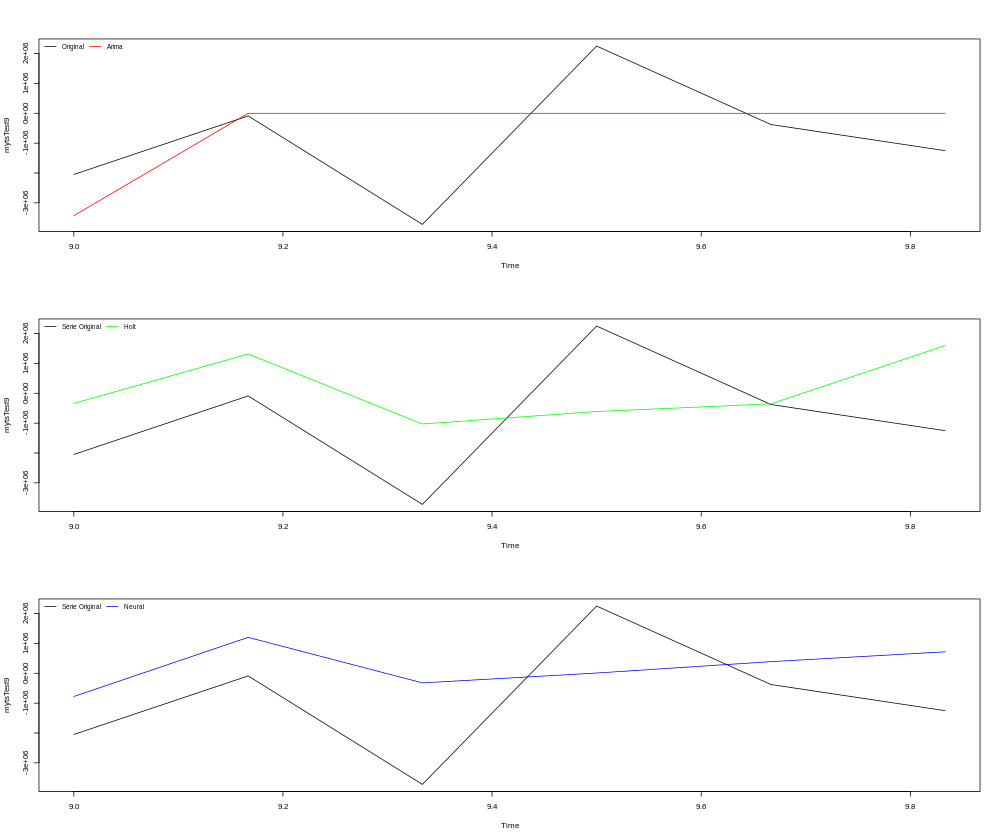

In [68]:
%%R -h 840 -w 1000 # ciclo 10

par(mfrow = c(3, 1))
plot(mytsTest9)
lines(prevArima8$mean, col="red")
legend("topleft", legend = c("Original", "Arima"), col = c("black", "red"), lty=1:1, cex=0.8, bty = "n", horiz=T)

plot(mytsTest9)
lines(prevHolt8$mean, col="green")
legend("topleft", legend = c("Série Original", "Holt"), col = c("black", "green"), lty=1:1, cex=0.8, bty = "n", horiz=T)

plot(mytsTest9)
lines(prevNeural8$mean, col="blue")
legend("topleft", legend = c("Série Original", "Neural"), col = c("black", "blue"), lty=1:1, cex=0.8, bty = "n", horiz=T)

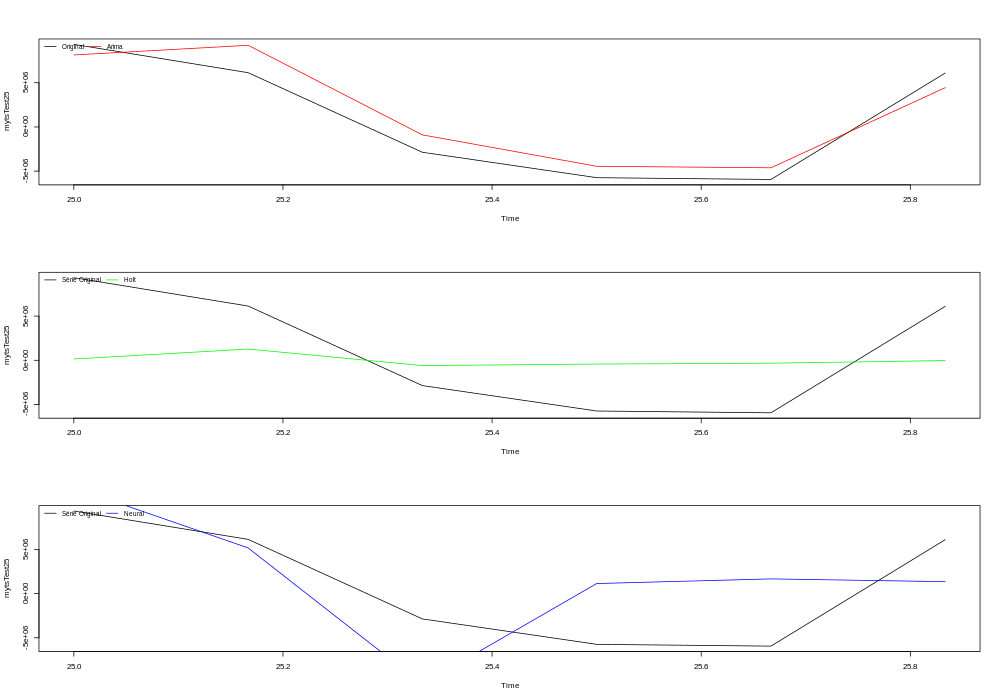

In [69]:
%%R -h 700 -w 1000 # ciclo 10

par(mfrow = c(3, 1))
plot(mytsTest25)
lines(prevArima24$mean, col="red")
legend("topleft", legend = c("Original", "Arima"), col = c("black", "red"), lty=1:1, cex=0.8, bty = "n", horiz=T)

plot(mytsTest25)
lines(prevHolt24$mean, col="green")
legend("topleft", legend = c("Série Original", "Holt"), col = c("black", "green"), lty=1:1, cex=0.8, bty = "n", horiz=T)

plot(mytsTest25)
lines(prevNeural24$mean, col="blue")
legend("topleft", legend = c("Série Original", "Neural"), col = c("black", "blue"), lty=1:1, cex=0.8, bty = "n", horiz=T)

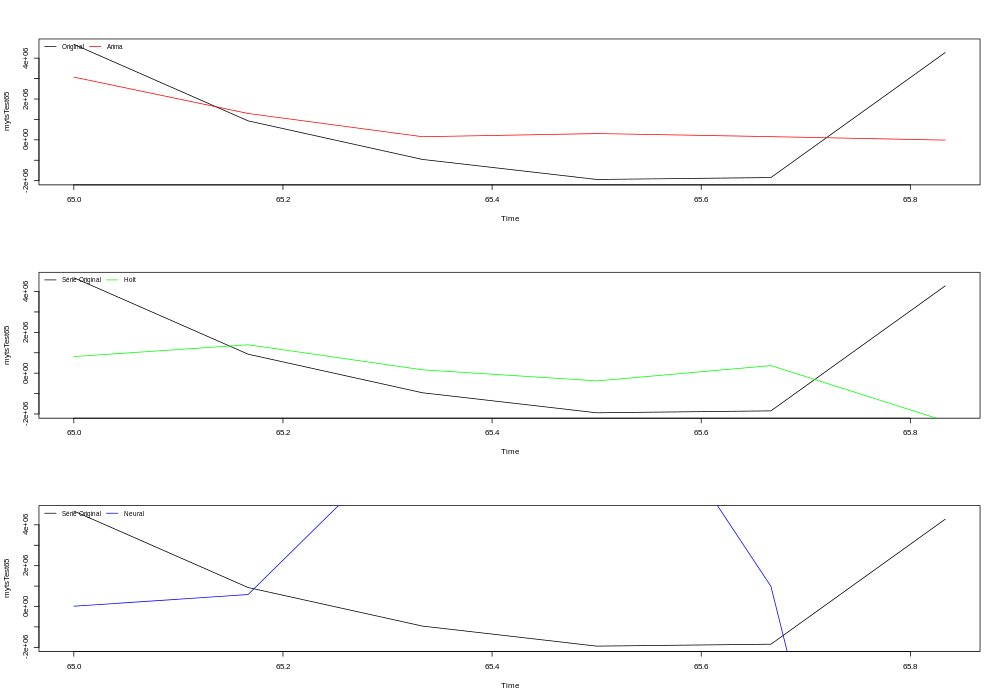

In [70]:
%%R -h 700 -w 1000 # ciclo 10

par(mfrow = c(3, 1))
plot(mytsTest65)
lines(prevArima64$mean, col="red")
legend("topleft", legend = c("Original", "Arima"), col = c("black", "red"), lty=1:1, cex=0.8, bty = "n", horiz=T)

plot(mytsTest65)
lines(prevHolt64$mean, col="green")
legend("topleft", legend = c("Série Original", "Holt"), col = c("black", "green"), lty=1:1, cex=0.8, bty = "n", horiz=T)

plot(mytsTest65)
lines(prevNeural64$mean, col="blue")
legend("toplefthttps://www.youtube.com/watch?v=_LUsKymAC2w", legend = c("Série Original", "Neural"), col = c("black", "blue"), lty=1:1, cex=0.8, bty = "n", horiz=T)

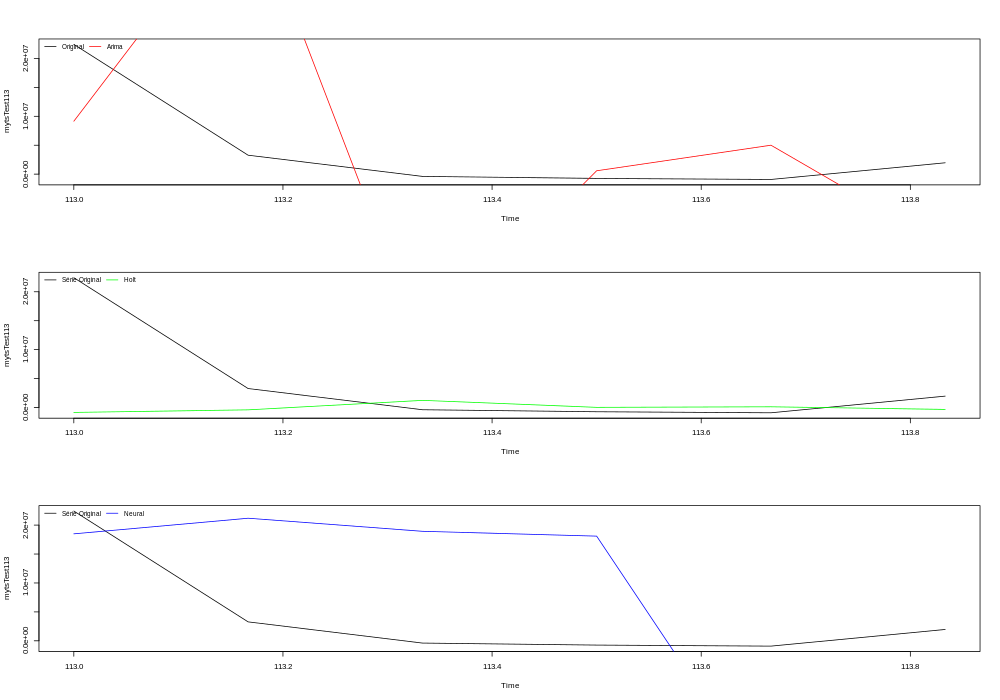

In [109]:
%%R -h 700 -w 1000 # ciclo 10

par(mfrow = c(3, 1))
plot(mytsTest113)
lines(prevArima112$mean, col="red")
legend("topleft", legend = c("Original", "Arima"), col = c("black", "red"), lty=1:1, cex=0.8, bty = "n", horiz=T)

plot(mytsTest113)
lines(prevHolt112$mean, col="green")
legend("topleft", legend = c("Série Original", "Holt"), col = c("black", "green"), lty=1:1, cex=0.8, bty = "n", horiz=T)

plot(mytsTest113)
lines(prevNeural112$mean, col="blue")
legend("topleft", legend = c("Série Original", "Neural"), col = c("black", "blue"), lty=1:1, cex=0.8, bty = "n", horiz=T)

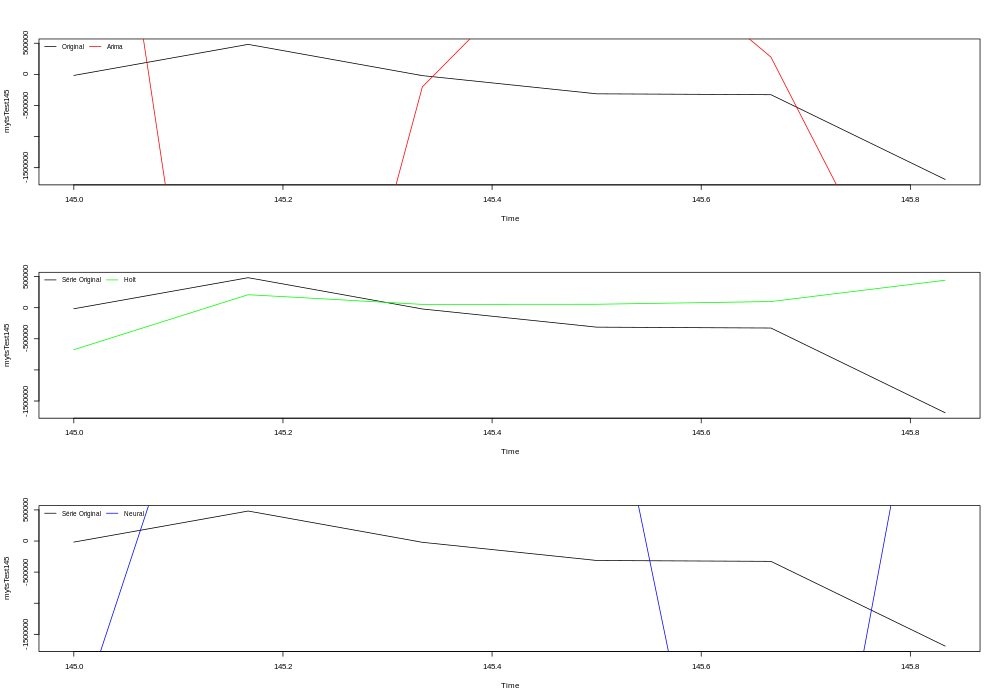

In [73]:
%%R -h 700 -w 1000 # ciclo 10

par(mfrow = c(3, 1))
plot(mytsTest145)
lines(prevArima144$mean, col="red")
legend("topleft", legend = c("Original", "Arima"), col = c("black", "red"), lty=1:1, cex=0.8, bty = "n", horiz=T)

plot(mytsTest145)
lines(prevHolt144$mean, col="green")
legend("topleft", legend = c("Série Original", "Holt"), col = c("black", "green"), lty=1:1, cex=0.8, bty = "n", horiz=T)

plot(mytsTest145)
lines(prevNeural144$mean, col="blue")
legend("topleft", legend = c("Série Original", "Neural"), col = c("black", "blue"), lty=1:1, cex=0.8, bty = "n", horiz=T)

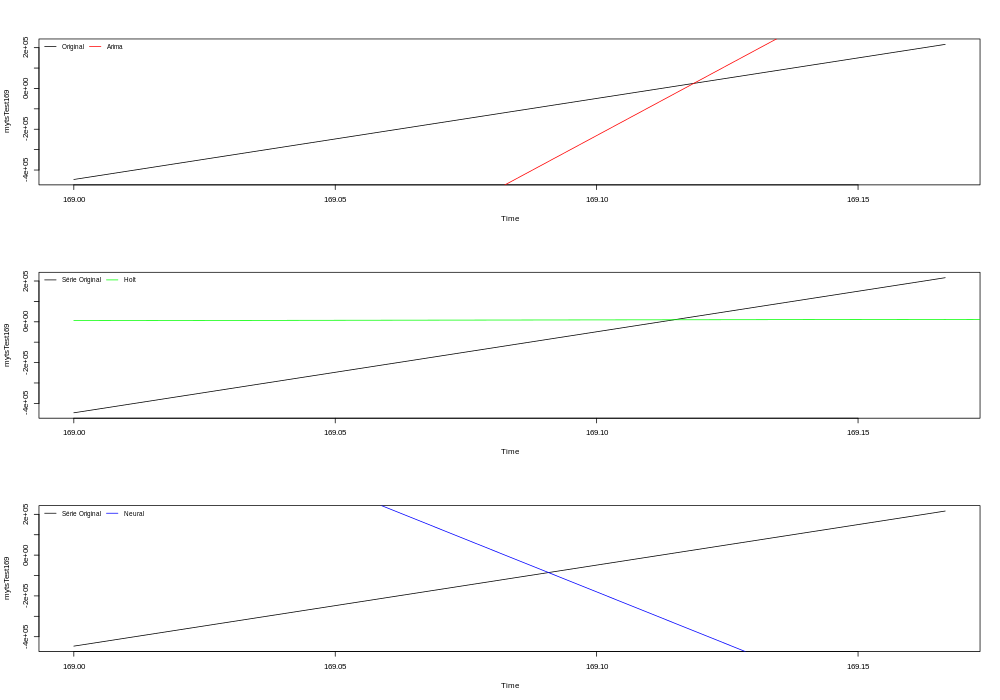

In [74]:
%%R -h 700 -w 1000 # ciclo 10

par(mfrow = c(3, 1))
plot(mytsTest169)
lines(prevArima168$mean, col="red")
legend("topleft", legend = c("Original", "Arima"), col = c("black", "red"), lty=1:1, cex=0.8, bty = "n", horiz=T)

plot(mytsTest169)
lines(prevHolt168$mean, col="green")
legend("topleft", legend = c("Série Original", "Holt"), col = c("black", "green"), lty=1:1, cex=0.8, bty = "n", horiz=T)

plot(mytsTest169)
lines(prevNeural168$mean, col="blue")
legend("topleft", legend = c("Série Original", "Neural"), col = c("black", "blue"), lty=1:1, cex=0.8, bty = "n", horiz=T)

## Avaliação - RMSE e MAPE

### RMSE

 [1]  2014710  1043979  5631795 29768362 10252041  8198555  2749285 17226973
 [9] 17957887  2435946 11002190 51099288 22037986 11757804 47756042  5666057
[17]  5670670  5029095  3389120  1192854


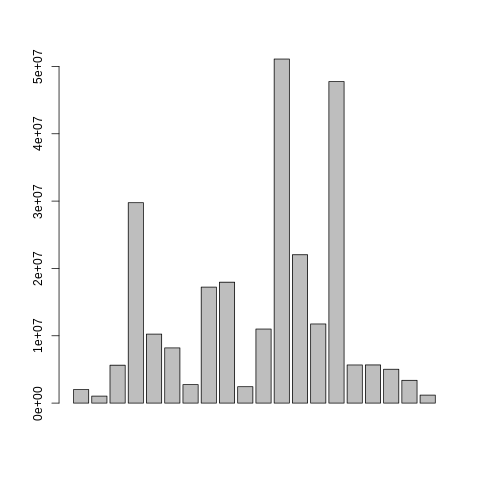

In [105]:
%%R

Neural_RMSE_inOrder = c(
  rmse(mytsTest9, prevNeural8$mean),
  rmse(mytsTest17, prevNeural16$mean),
  rmse(mytsTest25, prevNeural24$mean),
  rmse(mytsTest33, prevNeural32$mean),
  rmse(mytsTest41, prevNeural40$mean),
  rmse(mytsTest49, prevNeural48$mean),
  rmse(mytsTest57, prevNeural56$mean),
  rmse(mytsTest65, prevNeural64$mean),
  rmse(mytsTest73, prevNeural72$mean),
  rmse(mytsTest81, prevNeural80$mean),
  rmse(mytsTest89, prevNeural88$mean),
  rmse(mytsTest97, prevNeural96$mean),
  rmse(mytsTest113, prevNeural112$mean),
  rmse(mytsTest121, prevNeural120$mean),
  rmse(mytsTest129, prevNeural128$mean),
  rmse(mytsTest137, prevNeural136$mean),
  rmse(mytsTest145, prevNeural144$mean),
  rmse(mytsTest153, prevNeural152$mean),
  rmse(mytsTest161, prevNeural160$mean),
  rmse(mytsTest169, prevNeural168$mean)
)

print(Neural_RMSE_inOrder)
barplot(Neural_RMSE_inOrder)

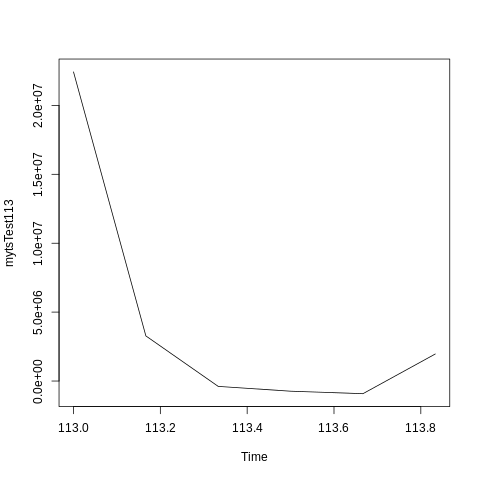

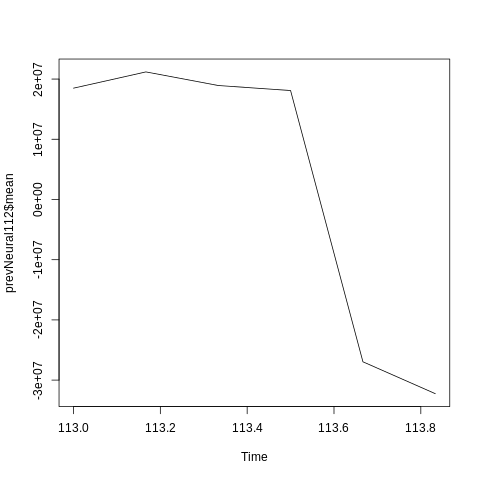

In [108]:
%%R

plot(mytsTest113)
plot(prevNeural112$mean)

 [1]  2178168.4  1156020.2  5925660.6  3320195.3  2820479.2  2283177.8
 [7]  4290281.1  3355954.3  1590512.5  1892258.9  4041510.0 61116477.9
[13]  9706216.8  3385508.0  5078137.9  2034144.9   946080.4  1554448.9
[19]  3747409.5   350673.4


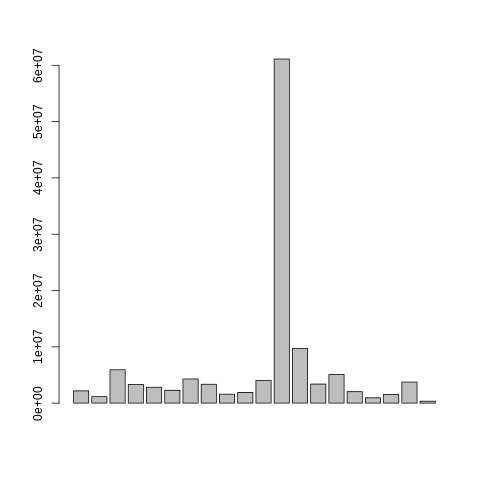

In [107]:
%%R
Holt_RMSE_inOrder = c(
  rmse(mytsTest9, prevHolt8$mean),
  rmse(mytsTest17, prevHolt16$mean),
  rmse(mytsTest25, prevHolt24$mean),
  rmse(mytsTest33, prevHolt32$mean),
  rmse(mytsTest41, prevHolt40$mean),
  rmse(mytsTest49, prevHolt48$mean),
  rmse(mytsTest57, prevHolt56$mean),
  rmse(mytsTest65, prevHolt64$mean),
  rmse(mytsTest73, prevHolt72$mean),
  rmse(mytsTest81, prevHolt80$mean),
  rmse(mytsTest89, prevHolt88$mean),
  rmse(mytsTest97, prevHolt96$mean),
  rmse(mytsTest113, prevHolt112$mean),
  rmse(mytsTest121, prevHolt120$mean),
  rmse(mytsTest129, prevHolt128$mean),
  rmse(mytsTest137, prevHolt136$mean),
  rmse(mytsTest145, prevHolt144$mean),
  rmse(mytsTest153, prevHolt152$mean),
  rmse(mytsTest161, prevHolt160$mean),
  rmse(mytsTest169, prevHolt168$mean)
)

print(Holt_RMSE_inOrder)
barplot(Holt_RMSE_inOrder)

 [1]  1938412.5  1046212.2  1874807.2  2925168.1  1521677.3   835773.9
 [7]  3010252.8  2287812.4  9315556.3  1196238.6  8600757.5 60864846.4
[13] 23590740.0  4509141.4  6199749.8  2286724.6  5896224.8  4496578.3
[19]  2840066.6   887159.6


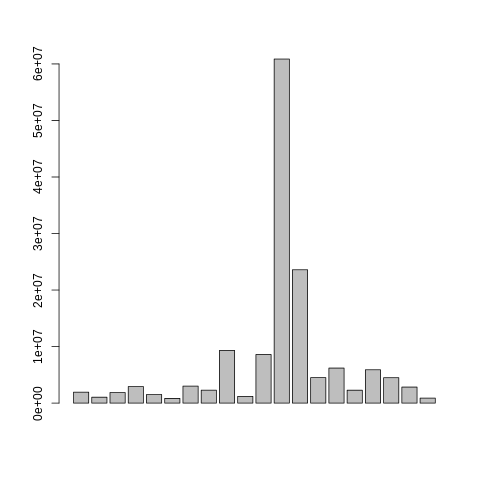

In [110]:
%%R

Arima_RMSE_inOrder = c(
  rmse(mytsTest9, prevArima8$mean),
  rmse(mytsTest17, prevArima16$mean),
  rmse(mytsTest25, prevArima24$mean),
  rmse(mytsTest33, prevArima32$mean),
  rmse(mytsTest41, prevArima40$mean),
  rmse(mytsTest49, prevArima48$mean),
  rmse(mytsTest57, prevArima56$mean),
  rmse(mytsTest65, prevArima64$mean),
  rmse(mytsTest73, prevArima72$mean),
  rmse(mytsTest81, prevArima80$mean),
  rmse(mytsTest89, prevArima88$mean),
  rmse(mytsTest97, prevArima96$mean),
  rmse(mytsTest113, prevArima112$mean),
  rmse(mytsTest121, prevArima120$mean),
  rmse(mytsTest129, prevArima128$mean),
  rmse(mytsTest137, prevArima136$mean),
  rmse(mytsTest145, prevArima144$mean),
  rmse(mytsTest153, prevArima152$mean),
  rmse(mytsTest161, prevArima160$mean),
  rmse(mytsTest169, prevArima168$mean)
)

print(Arima_RMSE_inOrder)
barplot(Arima_RMSE_inOrder)

### MAPE

 [1]   3.4777094   1.1227237   1.0458797  43.2344097   9.5326411  23.6746784
 [7]   0.8437679   5.0291194  34.4800319   3.1275635   5.9095026   1.4205216
[13]  21.0351363  15.5197206 291.6277990   3.8141689  55.5819739   9.3875992
[19]   2.1996034   3.9530422


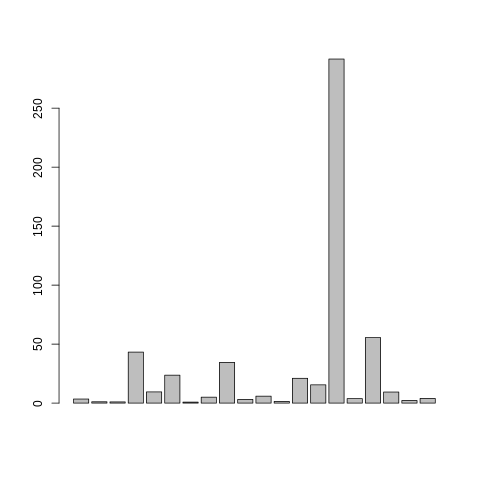

In [111]:
%%R

Neural_mape_inOrder = c(
  mape(mytsTest9, prevNeural8$mean),
  mape(mytsTest17, prevNeural16$mean),
  mape(mytsTest25, prevNeural24$mean),
  mape(mytsTest33, prevNeural32$mean),
  mape(mytsTest41, prevNeural40$mean),
  mape(mytsTest49, prevNeural48$mean),
  mape(mytsTest57, prevNeural56$mean),
  mape(mytsTest65, prevNeural64$mean),
  mape(mytsTest73, prevNeural72$mean),
  mape(mytsTest81, prevNeural80$mean),
  mape(mytsTest89, prevNeural88$mean),
  mape(mytsTest97, prevNeural96$mean),
  mape(mytsTest113, prevNeural112$mean),
  mape(mytsTest121, prevNeural120$mean),
  mape(mytsTest129, prevNeural128$mean),
  mape(mytsTest137, prevNeural136$mean),
  mape(mytsTest145, prevNeural144$mean),
  mape(mytsTest153, prevNeural152$mean),
  mape(mytsTest161, prevNeural160$mean),
  mape(mytsTest169, prevNeural168$mean)
)

print(Neural_mape_inOrder)
barplot(Neural_mape_inOrder)

 [1]  0.9457674  1.1494069  0.3397271  6.2479368  0.8813223  1.9331893
 [7]  1.6502492  0.8562739 15.0337643  1.0824445  4.3180932  1.2523671
[13] 17.4791143  3.5213504  6.8433365  1.9385327 85.2039131  6.0565949
[19]  1.1480743  2.3934528


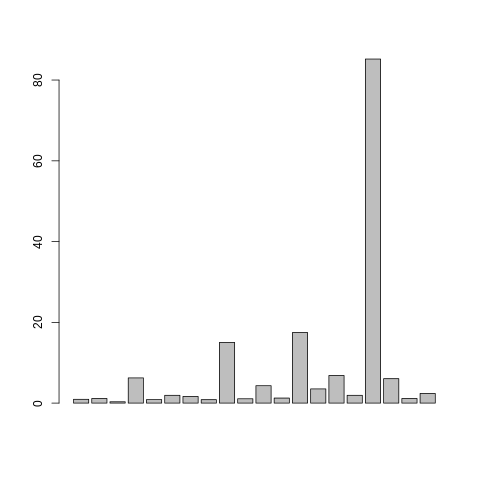

In [113]:
%%R

Arima_mape_inOrder = c(
  mape(mytsTest9, prevArima8$mean),
  mape(mytsTest17, prevArima16$mean),
  mape(mytsTest25, prevArima24$mean),
  mape(mytsTest33, prevArima32$mean),
  mape(mytsTest41, prevArima40$mean),
  mape(mytsTest49, prevArima48$mean),
  mape(mytsTest57, prevArima56$mean),
  mape(mytsTest65, prevArima64$mean),
  mape(mytsTest73, prevArima72$mean),
  mape(mytsTest81, prevArima80$mean),
  mape(mytsTest89, prevArima88$mean),
  mape(mytsTest97, prevArima96$mean),
  mape(mytsTest113, prevArima112$mean),
  mape(mytsTest121, prevArima120$mean),
  mape(mytsTest129, prevArima128$mean),
  mape(mytsTest137, prevArima136$mean),
  mape(mytsTest145, prevArima144$mean),
  mape(mytsTest153, prevArima152$mean),
  mape(mytsTest161, prevArima160$mean),
  mape(mytsTest169, prevArima168$mean)
)

print(Arima_mape_inOrder)
barplot(Arima_mape_inOrder)

 [1] 3.5314107 1.7534460 0.9071457 3.1303179 3.0200284 2.3666413 2.5129192
 [8] 1.0082380 1.8180376 3.0093620 1.4381574 1.0426812 1.6049101 1.0360724
[15] 1.2666534 1.7610715 7.6806703 1.0026828 1.0430865 0.9792371


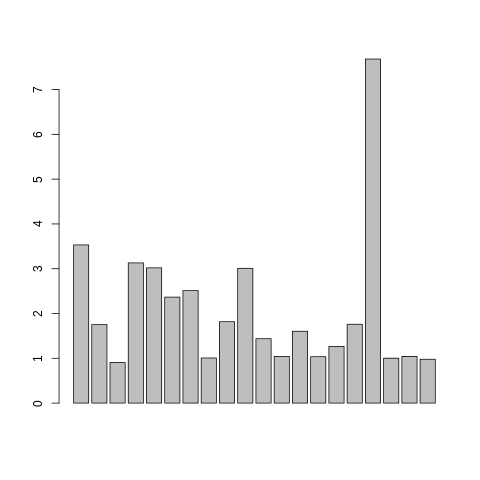

In [115]:
%%R

Holt_mape_inOrder = c(
  mape(mytsTest9, prevHolt8$mean),
  mape(mytsTest17, prevHolt16$mean),
  mape(mytsTest25, prevHolt24$mean),
  mape(mytsTest33, prevHolt32$mean),
  mape(mytsTest41, prevHolt40$mean),
  mape(mytsTest49, prevHolt48$mean),
  mape(mytsTest57, prevHolt56$mean),
  mape(mytsTest65, prevHolt64$mean),
  mape(mytsTest73, prevHolt72$mean),
  mape(mytsTest81, prevHolt80$mean),
  mape(mytsTest89, prevHolt88$mean),
  mape(mytsTest97, prevHolt96$mean),
  mape(mytsTest113, prevHolt112$mean),
  mape(mytsTest121, prevHolt120$mean),
  mape(mytsTest129, prevHolt128$mean),
  mape(mytsTest137, prevHolt136$mean),
  mape(mytsTest145, prevHolt144$mean),
  mape(mytsTest153, prevHolt152$mean),
  mape(mytsTest161, prevHolt160$mean),
  mape(mytsTest169, prevHolt168$mean)
)

print(Holt_mape_inOrder)
barplot(Holt_mape_inOrder)